# Movies Recommender (Spoiler Free Reviews)

In [128]:
# !pip install vaderSentiment
# !pip install scattertext

In [ ]:
import scattertext as st
import numpy as np
import pandas as pd
import json
import nltk
import re
import string
import pickle
import spacy
import vaderSentiment
import csv

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from textblob import TextBlob
from scipy.linalg import svd
from tqdm import tqdm
from collections import defaultdict
from collections import Counter
from nltk.stem import PorterStemmer, WordNetLemmatizer, wordnet
from nltk.tokenize import TreebankWordTokenizer, word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_details = pd.read_json('/content/drive/MyDrive/IMDB_movie_details.json', lines=True)
df_reviews = pd.read_json('/content/drive/MyDrive/IMDB_reviews.json', lines=True)

In [ ]:
df_reviews.head(2)

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.


In [ ]:
df_details.head(2)

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in..."
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",1h 45min,[Comedy],6.6,2013-11-01,Four boys around the age of 10 are friends in ...


# EDA

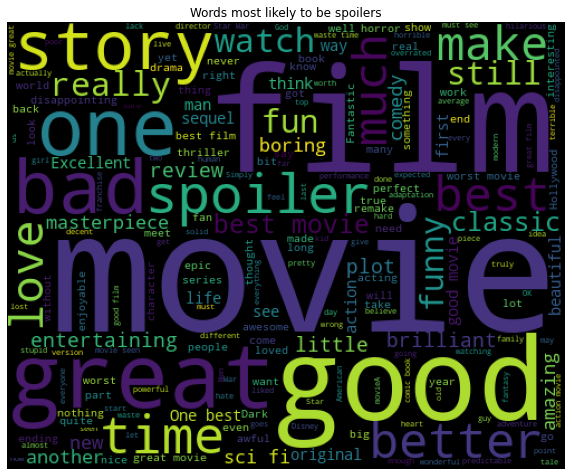

In [ ]:
x = df_reviews[df_reviews['is_spoiler']==True]
words = x['review_summary'][~pd.isnull(x['review_summary'])]
wordcloud = WordCloud(width=500,height=400).generate(''.join(words))
plt.figure(figsize=(10,12))
plt.axis('off')
plt.title('Words most likely to be spoilers')
plt.imshow(wordcloud)
plt.show()

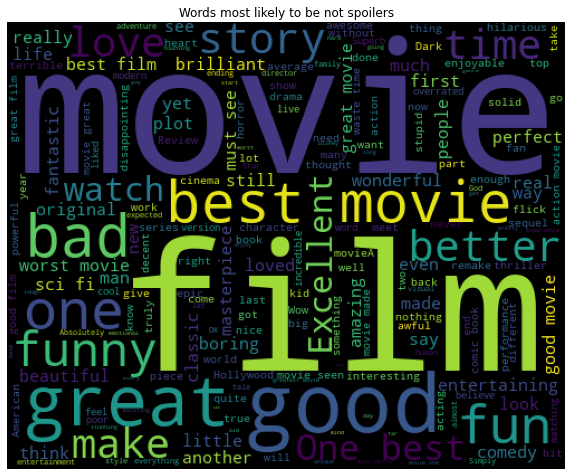

In [ ]:
x = df_reviews[df_reviews['is_spoiler']==False]
words = x['review_summary'][~pd.isnull(x['review_summary'])]
wordcloud = WordCloud(width=500,height=400).generate(''.join(words))
plt.figure(figsize=(10,12))
plt.axis('off')
plt.title('Words most likely to be not spoilers')
plt.imshow(wordcloud)
plt.show()

In [ ]:
#
corpus = st.CorpusFromPandas(df_reviews,
                             category_col='is_spoiler',
                             text_col='review_summary',
                             nlp=st.whitespace_nlp_with_sentences).build()

In [ ]:
df_reviews.is_spoiler.replace(True, 1, inplace=True)
df_reviews['is_spoiler'] = df_reviews.is_spoiler.astype(str)
html = st.produce_scattertext_explorer(
        corpus,
        category='1',
        category_name='Spoiler',
        not_category_name='Not Spoiler',
        minimum_term_frequency=10,
        pmi_threshold_coefficient=5,
        width_in_pixels=1000,
        metadata=df_reviews['movie_id']
        )
open('demo.html', 'wb').write(html.encode('utf-8'));

Text(0, 0.5, 'Number of Reviews')

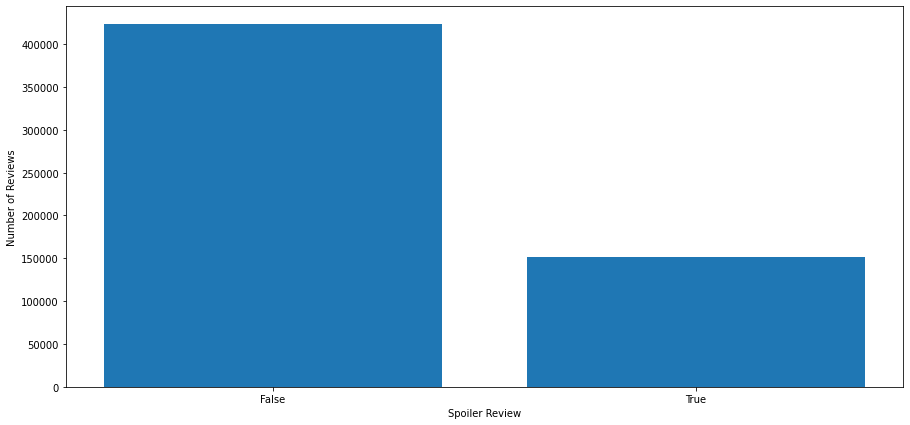

In [ ]:
# Spoiler or not (bar plot)
plt.figure(figsize=(15,7))
plt.bar(df_reviews.is_spoiler.astype(str).value_counts().index, df_reviews.is_spoiler.astype(str).value_counts());
plt.xlabel('Spoiler Review')
plt.ylabel('Number of Reviews')

Text(0, 0.5, 'Number of Movies')

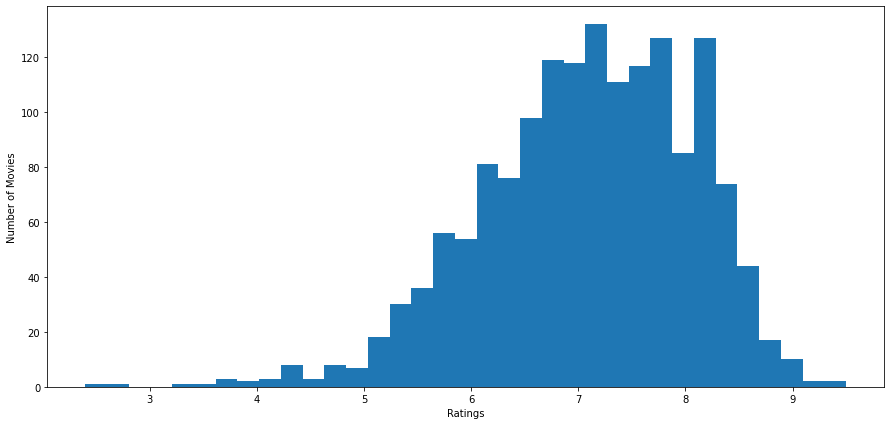

In [ ]:
# Histogram (ratings(df_details))
plt.figure(figsize=(15,7))
plt.hist(df_details.rating, bins=35);
plt.xlabel('Ratings')
plt.ylabel('Number of Movies')

In [ ]:
# Downsampling
df_reviews = pd.concat([df_reviews[df_reviews.is_spoiler == True].sample(500),
                        df_reviews[df_reviews.is_spoiler == False].sample(500)]).reset_index(drop=True)

# Sentiment Analysis

In this part, We will find positive reviews from the texts.

In [ ]:
analyser = SentimentIntensityAnalyzer()
def sentiment_analyzer_score(sentence):
    score = analyser.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))

In [ ]:
df_reviews.head(2)

In [ ]:
df_reviews['scores_text'] = df_reviews['review_text'].apply(lambda review: analyser.polarity_scores(review))
df_reviews.head(2)

In [ ]:
df_reviews['compound_text']  = df_reviews['scores_text'].apply(lambda score_dict: score_dict['compound'])
df_reviews.head(2)

In [ ]:
df_reviews['scores_summ'] = df_reviews['review_summary'].apply(lambda review: analyser.polarity_scores(review))
df_reviews.head(2)

In [ ]:
df_reviews['compound_summ']  = df_reviews['scores_summ'].apply(lambda score_dict: score_dict['compound'])
df_reviews.head(2)

In [ ]:
def Sentimnt(x):
    if x>= 0.05:
        return "Positive"
    elif x<= -0.05:
        return "Negative"
    else:
        return "Neutral"

df_reviews['Sentiment_text'] = df_reviews['compound_text'].apply(Sentimnt)
df_reviews['Sentiment_summ'] = df_reviews['compound_summ'].apply(Sentimnt)

df_reviews.head(2)

In [ ]:
if abs(df_reviews['compound_text']).all() >= abs(df_reviews['compound_summ']).all():
    df_reviews['final_sent'] = df_reviews['Sentiment_text']
else:
    df_reviews['final_sent'] = df_reviews['Sentiment_summ']
df_reviews.head(2)

In [ ]:
df_reviews = df_reviews[df_reviews.final_sent == 'Positive'][['movie_id','user_id','is_spoiler','review_text','review_summary']].reset_index(drop=True)

# Data Cleaning 

In [ ]:
df_details.drop(['duration','genre','rating','release_date'], axis=1, inplace = True)

In [ ]:
cleaned_movieID = []
for i in df_details.movie_id:
    emp_str = ''
    for ii in i:
        if ii.isdigit():
            emp_str+=ii
    cleaned_movieID.append(emp_str)
df_details['movie_id'] = cleaned_movieID

In [ ]:
cleaned = []
for i in df_reviews.movie_id:
    emp_str = ''
    for ii in i:
        if ii.isdigit():
            emp_str+=ii
    cleaned.append(emp_str)
df_reviews['movie_id'] = cleaned

In [ ]:
cleaned = []
for i in df_reviews.user_id:
    emp_str = ''
    for ii in i:
        if ii.isdigit():
            emp_str+=ii
    cleaned.append(emp_str)
df_reviews['user_id'] = cleaned

In [ ]:
df_reviews.is_spoiler.replace(True, 1, inplace=True)
df_reviews['is_spoiler'] = df_reviews.is_spoiler.astype(int)

In [ ]:
df_reviews.head(2)

In [ ]:
df_details.head(2)

In [ ]:
df_reviews.fillna('Missing', inplace=True)
df_details.fillna('Missing', inplace=True)

NLP Preproccessing

In [ ]:
def data_cleaning(data, lemmatizer=WordNetLemmatizer()):
    list_of_sent = []
    for a_row in tqdm(data.values):
        a_row = re.sub('[%s]' %re.escape(string.punctuation),'',re.sub('\w*\d\w*','', a_row)).lower().split(' ') # remove all punctuations
        clean_row = ''
        for a_word in a_row:
            if a_word.isalpha() and a_word not in stopwords.words('english'):
                if lemmatizer:
                    a_word = lemmatizer.lemmatize(a_word, pos='a')
                    a_word = lemmatizer.lemmatize(a_word, pos='s')
                    a_word = lemmatizer.lemmatize(a_word, pos='r')
                    a_word = lemmatizer.lemmatize(a_word, pos='n')
                    a_word = lemmatizer.lemmatize(a_word, pos='v')
                clean_row = clean_row + ' ' + a_word
        list_of_sent.append(clean_row.strip())
    return list_of_sent

In [ ]:
df_details['plot_summary'] = data_cleaning(df_details['plot_summary'])
df_details['plot_synopsis'] = data_cleaning(df_details['plot_synopsis'])

In [ ]:
df_reviews['review_summary'] = data_cleaning(df_reviews['review_summary'])
df_reviews['review_text'] = data_cleaning(df_reviews['review_text'])

In [ ]:
df_reviews.head(2)

In [ ]:
df_details.head(2)

In [ ]:
df_details.fillna('Missing', inplace=True)
df_reviews.fillna('Missing', inplace=True)

In [ ]:
# Download as a backup
df_reviews.to_json('/content/drive/MyDrive/df_reviews.json')
df_details.to_json('/content/drive/MyDrive/df_details.json')

# Read Cleaned Data

In [ ]:
df_reviews = pd.read_json('/content/drive/MyDrive/df_reviews.json')
df_details = pd.read_json('/content/drive/MyDrive/df_details.json')

In [ ]:
# df_details.fillna('Missing', inplace=True)
# df_reviews.fillna('Missing', inplace=True)

In [ ]:
df_reviews.head(2)

In [ ]:
df_details.head(2)

# Finding Spoilers

We'll find spoilers using cosine similarities

In [ ]:
def cos_sim(plots,reviews):
    output = []
    for review in tqdm(reviews.values):
        a_row = []
        for a_plot in plots.values:
            a_row.append(np.dot(review, a_plot)/(np.linalg.norm(review)*np.linalg.norm(a_plot)))
        output.append(a_row)
    return output

In [ ]:
def get_cos_sim(cos_sim_):
    num=0
    dumm_list_ = []
    for x in df_reviews.movie_id:
        dumm_list_.append(cos_sim_.loc[num,int(x)])
        num+=1
    return dumm_list_

### Using TfidfVectorizer

Using 'plot_synopsis' that contains the complete plot compared with the complete and the summarized reviews.

In [ ]:
vectorizer = TfidfVectorizer(decode_error='ignore')
tfidf_plot_synopsis = vectorizer.fit_transform(df_details.plot_synopsis)
tfidf_review_text = vectorizer.transform(df_reviews.review_text)
tfidf_review_summary = vectorizer.transform(df_reviews.review_summary)

In [ ]:
tfidf_plot_synopsis = pd.DataFrame(tfidf_plot_synopsis.toarray(), columns=vectorizer.get_feature_names())
tfidf_review_text = pd.DataFrame(tfidf_review_text.toarray(), columns=vectorizer.get_feature_names())
tfidf_review_summary = pd.DataFrame(tfidf_review_summary.toarray(), columns=vectorizer.get_feature_names())

In [ ]:
cos_sim_tfidf_plot_synopsis_review_text = pd.DataFrame(cos_sim(tfidf_plot_synopsis,tfidf_review_text), columns = df_details.movie_id.values)
cos_sim_tfidf_plot_synopsis_review_summary = pd.DataFrame(cos_sim(tfidf_plot_synopsis,tfidf_review_summary), columns = df_details.movie_id.values)

In [ ]:
cos_sim_tfidf_plot_synopsis_review_text.to_json('/content/drive/MyDrive/cos_sim_tfidf_plot_synopsis_review_text.json')
cos_sim_tfidf_plot_synopsis_review_summary.to_json('/content/drive/MyDrive/cos_sim_tfidf_plot_synopsis_review_summary.json')

In [ ]:
cos_sim_tfidf_plot_synopsis_review_text = pd.read_json('/content/drive/MyDrive/cos_sim_tfidf_plot_synopsis_review_text.json')
cos_sim_tfidf_plot_synopsis_review_summary = pd.read_json('/content/drive/MyDrive/cos_sim_tfidf_plot_synopsis_review_summary.json')

plot_summary

In [ ]:
tfidf_plot_summary = vectorizer.fit_transform(df_details.plot_summary)
tfidf_review_text = vectorizer.transform(df_reviews.review_text)
tfidf_review_summary = vectorizer.transform(df_reviews.review_summary)

In [ ]:
tfidf_plot_summary = pd.DataFrame(tfidf_plot_summary.toarray(), columns=vectorizer.get_feature_names())
tfidf_review_text = pd.DataFrame(tfidf_review_text.toarray(), columns=vectorizer.get_feature_names())
tfidf_review_summary = pd.DataFrame(tfidf_review_summary.toarray(), columns=vectorizer.get_feature_names())

In [ ]:
cos_sim_tfidf_plot_summary_review_text = pd.DataFrame(cos_sim(tfidf_plot_summary,tfidf_review_text), columns = df_details.movie_id.values)
cos_sim_tfidf_plot_summary_review_summary = pd.DataFrame(cos_sim(tfidf_plot_summary,tfidf_review_summary), columns = df_details.movie_id.values)

In [ ]:
cos_sim_tfidf_plot_summary_review_text.to_json('/content/drive/MyDrive/cos_sim_tfidf_plot_summary_review_text.json')
cos_sim_tfidf_plot_summary_review_summary.to_json('/content/drive/MyDrive/cos_sim_tfidf_plot_summary_review_summary.json')

In [ ]:
cos_sim_tfidf_plot_summary_review_text = pd.read_json('/content/drive/MyDrive/cos_sim_tfidf_plot_summary_review_text.json')
cos_sim_tfidf_plot_summary_review_summary = pd.read_json('/content/drive/MyDrive/cos_sim_tfidf_plot_summary_review_summary.json')

We'll now try to find a way to discriminate between the spoiler reviews and the non-spoiler ones.

In [ ]:
df_reviews['tfidf_plotsyn_revtxt'] = get_cos_sim(cos_sim_tfidf_plot_synopsis_review_text)
df_reviews['tfidf_plotsyn_revsum'] = get_cos_sim(cos_sim_tfidf_plot_synopsis_review_summary)
df_reviews['tfidf_plotsum_revtxt'] = get_cos_sim(cos_sim_tfidf_plot_summary_review_text)
df_reviews['tfidf_plotsum_revsum'] = get_cos_sim(cos_sim_tfidf_plot_summary_review_summary)

In [ ]:
df_reviews.head(2)

In [ ]:
plt.hist(df_reviews[df_reviews.is_spoiler == 0]['tfidf_plotsum_revtxt'], bins=50);

In [ ]:
plt.hist(df_reviews[df_reviews.is_spoiler == 1]['tfidf_plotsum_revtxt'], bins=50);

### Using CountVectorizer

plot_synopsis

In [ ]:
vectorizer = CountVectorizer(decode_error='ignore')
cv_plot_synopsis = vectorizer.fit_transform(df_details.plot_synopsis)
cv_review_text = vectorizer.transform(df_reviews.review_text)
cv_review_summary = vectorizer.transform(df_reviews.review_summary)

In [ ]:
cv_plot_synopsis = pd.DataFrame(cv_plot_synopsis.toarray(), columns=vectorizer.get_feature_names())
cv_review_text = pd.DataFrame(cv_review_text.toarray(), columns=vectorizer.get_feature_names())
cv_review_summary = pd.DataFrame(cv_review_summary.toarray(), columns=vectorizer.get_feature_names())

In [ ]:
cos_sim_cv_plot_synopsis_review_text = pd.DataFrame(cos_sim(cv_plot_synopsis,cv_review_text), columns = df_details.movie_id.values)
cos_sim_cv_plot_synopsis_review_summary = pd.DataFrame(cos_sim(cv_plot_synopsis,cv_review_summary), columns = df_details.movie_id.values)

In [ ]:
cos_sim_cv_plot_synopsis_review_text.to_json('/content/drive/MyDrive/cos_sim_cv_plot_synopsis_review_text.json')
cos_sim_cv_plot_synopsis_review_summary.to_json('/content/drive/MyDrive/cos_sim_cv_plot_synopsis_review_summary.json')

In [ ]:
cos_sim_cv_plot_synopsis_review_text = pd.read_json('/content/drive/MyDrive/cos_sim_cv_plot_synopsis_review_text.json')
cos_sim_cv_plot_synopsis_review_summary = pd.read_json('/content/drive/MyDrive/cos_sim_cv_plot_synopsis_review_summary.json')

plot_summary

In [ ]:
cv_plot_summary = vectorizer.fit_transform(df_details.plot_summary)
cv_review_text = vectorizer.transform(df_reviews.review_text)
cv_review_summary = vectorizer.transform(df_reviews.review_summary)

In [ ]:
cv_plot_summary = pd.DataFrame(cv_plot_summary.toarray(), columns=vectorizer.get_feature_names())
cv_review_text = pd.DataFrame(cv_review_text.toarray(), columns=vectorizer.get_feature_names())
cv_review_summary = pd.DataFrame(cv_review_summary.toarray(), columns=vectorizer.get_feature_names())

In [ ]:
cos_sim_cv_plot_summary_review_text = pd.DataFrame(cos_sim(cv_plot_summary,cv_review_text), columns = df_details.movie_id.values)
cos_sim_cv_plot_summary_review_summary = pd.DataFrame(cos_sim(cv_plot_summary,cv_review_summary), columns = df_details.movie_id.values)

In [ ]:
cos_sim_cv_plot_summary_review_text.to_json('/content/drive/MyDrive/cos_sim_cv_plot_summary_review_text.json')
cos_sim_cv_plot_summary_review_summary.to_json('/content/drive/MyDrive/cos_sim_cv_plot_summary_review_summary.json')

In [ ]:
cos_sim_cv_plot_summary_review_text = pd.read_json('/content/drive/MyDrive/cos_sim_cv_plot_summary_review_text.json')
cos_sim_cv_plot_summary_review_summary = pd.read_json('/content/drive/MyDrive/cos_sim_cv_plot_summary_review_summary.json')

In [ ]:
df_reviews['cv_plotsyn_revtxt'] = get_cos_sim(cos_sim_cv_plot_synopsis_review_text)
df_reviews['cv_plotsyn_revsum'] = get_cos_sim(cos_sim_cv_plot_synopsis_review_summary)
df_reviews['cv_plotsum_revtxt'] = get_cos_sim(cos_sim_cv_plot_summary_review_text)
df_reviews['cv_plotsum_revsum'] = get_cos_sim(cos_sim_cv_plot_summary_review_summary)

In [ ]:
df_reviews.head(2)

In [ ]:
plt.hist(df_reviews[df_reviews.is_spoiler == 0]['cv_plotsum_revtxt'], bins=50);

In [ ]:
plt.hist(df_reviews[df_reviews.is_spoiler == 1]['cv_plotsum_revtxt'], bins=50);

### Using SpaCy

In [ ]:
nlp = spacy.load('en_core_web_md')
spacy_plotsyn_revtxt = []
spacy_plotsyn_revsum = []
spacy_plotsum_revtxt = []
spacy_plotsum_revsum = []

for idx in df_reviews.index:
    
    mov_ID = df_reviews['movie_id'].iloc[idx]
    revtxt = df_reviews['review_text'].iloc[idx]
    revsum = df_reviews['review_summary'].iloc[idx]

    plot_syn = nlp(df_details[df_details.movie_id == mov_ID]['plot_synopsis'].values[0])
    plot_sum = nlp(df_details[df_details.movie_id == mov_ID]['plot_summary'].values[0])
    rev_txt = nlp(revtxt)
    rev_sum = nlp(revsum)
    
    spacy_plotsyn_revtxt.append(plot_syn.similarity(rev_txt))
    spacy_plotsyn_revsum.append(plot_syn.similarity(rev_sum))
    spacy_plotsum_revtxt.append(plot_sum.similarity(rev_txt))
    spacy_plotsum_revsum.append(plot_sum.similarity(rev_sum))
    

df_reviews['spacy_plotsyn_revtxt'] = spacy_plotsyn_revtxt
df_reviews['spacy_plotsyn_revsum'] = spacy_plotsyn_revsum
df_reviews['spacy_plotsum_revtxt'] = spacy_plotsum_revtxt
df_reviews['spacy_plotsum_revsum'] = spacy_plotsum_revsum

In [ ]:
df_reviews.to_json('/content/drive/MyDrive/df_reviews.json')

In [ ]:
df_reviews = pd.read_json('/content/drive/MyDrive/df_reviews.json')

In [ ]:
plt.hist([df_reviews[df_reviews.is_spoiler == 1]['spacy_plotsyn_revtxt'], 
          df_reviews[df_reviews.is_spoiler == 0]['spacy_plotsyn_revtxt']], bins=50);

In [ ]:
plt.hist([df_reviews[df_reviews.is_spoiler == 1]['spacy_plotsyn_revsum'], 
          df_reviews[df_reviews.is_spoiler == 0]['spacy_plotsyn_revsum']], bins=50);

In [ ]:
plt.hist([df_reviews[df_reviews.is_spoiler == 1]['spacy_plotsum_revtxt'], 
          df_reviews[df_reviews.is_spoiler == 0]['spacy_plotsum_revtxt']], bins=50);

In [ ]:
plt.hist([df_reviews[df_reviews.is_spoiler == 1]['spacy_plotsum_revsum'], 
          df_reviews[df_reviews.is_spoiler == 0]['spacy_plotsum_revsum']], bins=50);

# Recommender

In [ ]:
movie_user_map = defaultdict(list)
user_movie_map = defaultdict(list)

In [ ]:
df_reviews.to_csv('/content/drive/MyDrive/df_reviews.csv')
with open('/content/drive/MyDrive/df_reviews.csv', 'r') as csvfile:
    w = csv.reader(csvfile)
    for row in w:
        user_movie_map[row[1]].append(row[2])
        movie_user_map[row[2]].append(row[1])

In [ ]:
for u in user_movie_map['tt0289879']:
  print('user who watched the movie',u)
  print('movies the user watched',movie_user_map[u])

In [ ]:
for m in movie_user_map['ur1722042']:
    print('movie the user watched', m)
    for u in user_movie_map[m]:
        print(u,'--- ',movie_user_map[u])

In [ ]:
def get_similar_movie(user_movie_map,movie_user_map,m):
    biglist = []
    for u in user_movie_map[m]: # get all users that liked this movie
        biglist.extend(movie_user_map[u]) # find all other movies those users liked and add to biglist
    return Counter(biglist).most_common(4)[1:] # use counter to 'count' the other movies that show up most common

In [ ]:
def get_movie_recommendation(user_movie_map,movie_user_map,u1):
    biglist = []
    for m in movie_user_map[u1]: # for the movies a specific user likes
        for u in user_movie_map[m]: # get other users who liked those movies
            biglist.extend(movie_user_map[u]) # find the other movies those "similar folks" most liked
    return Counter(biglist).most_common(3) # return tuples of (most common id, count)

In [ ]:
get_similar_movie(user_movie_map,movie_user_map,'tt0289879')

In [ ]:
get_movie_recommendation(user_movie_map,movie_user_map,'ur1722042')